In [8]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import random

In [2]:
def homogeneous_poisson_on_rectangle(intensity, x_lim, y_lim):
    """
    Function that generates a random Poisson point process on a rectangle with a given intensity.

    :param intensity: The intensity of the Poisson point process.
    :param x_lim: A tuple or list specifying the lower and upper limits of the x-axis of the rectangle.
    :param y_lim: A tuple or list specifying the lower and upper limits of the y-axis of the rectangle.
    :return: A Pandas DataFrame with generated points as two columns: "X" for x-coordinates and "Y" for y-coordinates.
    """
    # Calculate the expected number of points based on the intensity and rectangle dimensions
    x_len = x_lim[1] - x_lim[0]
    y_len = y_lim[1] - y_lim[0]
    exp = intensity * x_len * y_len

    # Generate the number of points from a Poisson distribution
    n = np.random.poisson(exp)

    # Generate random x and y coordinates within the rectangle
    df = pd.DataFrame()
    df["X"] = np.random.rand(n) * (x_lim[1] - x_lim[0]) + x_lim[0]
    df["Y"] = np.random.rand(n) * (y_lim[1] - y_lim[0]) + y_lim[0]

    return df

In [3]:
def generate_points_on_circle(radius, num_points, center):
    """
    Function that generates a random point process on a circle with a given radius.

    :param radius: The radius of the circle.
    :param num_points: The number of points to be generated on the circle.
    :param center: A tuple or list specifying the center coordinates (x, y) of the circle.
    :return: A Pandas DataFrame with generated points as two columns: "X" for x-coordinates and "Y" for y-coordinates.
    """
    # Generate random angles from 0 to 2 * pi
    angles = np.random.uniform(0, 2 * np.pi, num_points)

    # Convert polar coordinates (radius, angle) to Cartesian coordinates (x, y)
    x_temp = radius * np.cos(angles) + center[0]
    y_temp = radius * np.sin(angles) + center[1]

    # Add small random perturbations to x and y coordinates
    x = [el + np.random.uniform(-radius / 50, radius / 50) for el in x_temp]
    y = [el + np.random.uniform(-radius / 50, radius / 50) for el in y_temp]

    # Create a Pandas DataFrame with the generated points
    df = pd.DataFrame()
    df["X"] = x
    df["Y"] = y

    return df


In [4]:
def points_on_circle_polygon(num_points, polygon, crs):
    """
    Generates points on the circumference of a circle centered at the centroid of the input polygon geometry.

    :param num_points: Number of points to generate on the circle.
    :param polygon: A polygon geometry from the geopandas library.
    :param crs: The coordinate reference system (CRS) for the generated points.
    :return: A geopandas GeoDataFrame containing the generated points that fall within the input polygon.
    """
    # Calculate the bounds of the input polygon
    bounds = polygon.bounds
    # Determine the radius of the circle as one-third of the minimum of the x and y bounds
    radius = np.min([(bounds.maxx - bounds.minx)[0], (bounds.maxy - bounds.miny)[0]]) / 3
    # Calculate the centroid of the polygon
    centroid = polygon.centroid
    # Generate points on the circle using a previously defined function (generate_points_on_circle)
    df_1 = generate_points_on_circle(radius, num_points, [centroid.x[0], centroid.y[0]])

    # Create a temporary GeoDataFrame to store the generated points
    temp = gpd.GeoDataFrame()
    # Convert the generated points to GeoPoints and add them to the temporary GeoDataFrame
    temp['geometry'] = gpd.points_from_xy(df_1['X'], df_1['Y'], crs=crs)

    # Create a temporary GeoDataFrame to store the multipolygon (same as the input polygon)
    mult_polygon = gpd.GeoDataFrame()
    # Loop through each point in the temporary GeoDataFrame
    for i in range(len(temp)):
        # Concatenate the multipolygon with a new GeoDataFrame containing the same polygon geometry
        mult_polygon = pd.concat(
            [mult_polygon, gpd.GeoDataFrame({'Nazwa': 'wojewodztwo', 'geometry': polygon.geometry})]).reset_index(
            drop=True)

    # Check if each point is within the multipolygon (i.e., the input polygon)
    temp['is_in'] = temp.within(mult_polygon)

    # Create a final GeoDataFrame containing only the points that fall within the input polygon
    df = gpd.GeoDataFrame({'geometry': temp[temp['is_in'] == True].geometry}).reset_index(drop=True)

    # Return the GeoDataFrame with the generated points within the input polygon
    return df

In [5]:
def homogeneous_poisson_on_polygon(intensity, polygon, crs):
    """
    Function that generates a homogeneous Poisson point process on a polygonal geometry using a previously defined function
    for generating Poisson points on a rectangle.

    :param intensity: The intensity or average density of points in the Poisson process.
    :param polygon: A polygon geometry from the geopandas library on which the Poisson points will be generated.
    :param crs: The coordinate reference system (CRS) for the generated points.
    :return: A geopandas GeoDataFrame containing the generated points that fall within the input polygon.
    """
    # Calculate the bounding box of the input polygon
    bounds = polygon.bounds

    # Generate Poisson points on a rectangle that bounds the polygon
    df_poisson = homogeneous_poisson_on_rectangle(intensity, [float(bounds.minx[0]), float(bounds.maxx[0])],
                                                  [float(bounds.miny[0]), float(bounds.maxy[0])])

    # Create a geopandas GeoDataFrame to store the generated points
    temp = gpd.GeoDataFrame()
    temp['geometry'] = gpd.points_from_xy(df_poisson['X'], df_poisson['Y'], crs=crs)

    # Check if each point falls within the polygon
    mult_polygon = gpd.GeoDataFrame()
    for i in range(len(temp)):
        mult_polygon = pd.concat(
            [mult_polygon, gpd.GeoDataFrame({'Nazwa': 'wojewodztwo', 'geometry': polygon.geometry})]).reset_index(
            drop=True)
    temp['is_in'] = temp.within(mult_polygon)

    # Create a new GeoDataFrame containing only the points that fall within the polygon
    df = gpd.GeoDataFrame({'geometry': temp[temp['is_in'] == True].geometry}).reset_index(drop=True)

    return df

In [6]:
def generate_permutations_with_fixed_element(n, population_size, first=0):
    """
    Function that generates m permutations of an n-element set, where
    the specified element always occupies the first position.

    :param n: Length of set which will be permutated.
    :param population_size: Number of permutations to generate.
    :param first: Element that should be in the first position of permutations.
    :return: List of m permutations of an n-element set with the element in the first position.
    """

    # Generate list from 0 to n
    iterable = list(range(n))

    # Check if the element is present in the iterable
    if first not in iterable:
        raise ValueError("Element must be present in the iterable set.")

    # Remove the element from the iterable set
    iterable.remove(first)

    # Generate permutations using np.random.permutation
    # and add the element to the first position in each permutation
    permutations = []
    for _ in range(population_size):
        perm = np.random.permutation(iterable).tolist()
        perm.insert(0, first)
        permutations.append(perm)

    return np.array(permutations)

In [7]:
def calculate_distances(points, perms):
    """
    Function that calculates distances between consecutive points in a geodataframe.
    Order is arranged by permutations.

    :param points: A geodataframe containing point data with x and y coordinates.
    :param perms: An array representing permutations of indices that define the order of points.
    :return: An array containing the sum of distances for each permutation of points provided in perms.
    """

    # Extract x and y coordinates from the geodataframe
    x = np.array(points.geometry.x)
    y = np.array(points.geometry.y)

    # Create a shifted version of perms
    perms_shift = np.roll(perms, -1)

    # Create arrays for x and y coordinates of points in specified order and shifted order
    x_new = x[perms]
    y_new = y[perms]
    x_shifted = x[perms_shift]
    y_shifted = y[perms_shift]

    # Calculate distances using Euclidean distance formula
    distances = np.sqrt((x_shifted - x_new) ** 2 + (y_shifted - y_new) ** 2)

    # Return the sum of distances for each permutation along axis 1
    return np.sum(distances, axis=1)


In [9]:
def ranking_selection(costs, num_parents):
    """
    Select parents based on ranking of costs.

    :param costs: List of costs.
    :param num_parents: Number of parents to select.
    :return: List of selected parents' indices.
    """
    # Create a DataFrame from the list of costs
    df = pd.DataFrame(costs, columns=['cost'])

    # Rank the DataFrame in descending order
    df['rank'] = df['cost'].rank()
    df = df.sort_values('rank', ascending=False)

    # Calculate the total fitness
    total_fitness = sum(i for i in range(1, len(costs) + 1))
    selection_probabilities = [i / total_fitness for i in range(1, len(costs) + 1)]

    # Select parents based on selection probabilities
    parents_idxs = []
    for _ in range(num_parents):
        rand = random.random()  # Generate a random number between 0 and 1
        cumulative_prob = 0
        for i, prob in enumerate(selection_probabilities):
            cumulative_prob += prob
            if rand <= cumulative_prob:
                parents_idxs.append(df.index[i])
                break

    return parents_idxs


In [11]:
def pmx_crossover(parent1, parent2):
    """
    Performs Partially-Mapped Crossover (PMX) on two parents to generate two children.

    :param parent1: First parent chromosome.
    :param parent2: Second parent chromosome.
    :return: Two children chromosomes resulting from PMX crossover.
    """
    # Select two random crossover points
    crossover_points = random.sample(range(1, len(parent1)), 2)
    crossover_points.sort()

    # Create copies of parents
    child1 = parent1.copy()
    child2 = parent2.copy()

    # Perform PMX crossover
    for i in range(crossover_points[0], crossover_points[1]):
        # Swap genes between parents
        gene1 = parent1[i]
        gene2 = parent2[i]
        index1 = np.where(parent1 == gene2)[0][0]
        index2 = np.where(parent2 == gene1)[0][0]
        child1[i], child1[index1] = child1[index1], child1[i]
        child2[i], child2[index2] = child2[index2], child2[i]

    return child1, child2

In [12]:
def crossover(perms, parents_idxs, prob):
    """
    Performs crossover operation on a set of permutations based on parent indices.

    :param perms: Array of permutations.
    :param parents_idxs: Indices of selected parent permutations.
    :param prob: Crossover probability.
    :return: Array of children permutations resulting from crossover operation.
    """
    parents = perms[parents_idxs]
    pairs = []
    children = []

    # Create pairs of parents for crossover
    for i in range(len(parents_idxs) * 2):
        p1, p2 = random.choices(parents_idxs, k=2)
        pairs.append((p1, p2))

    # Perform crossover on each pair of parents
    for idx1, idx2 in pairs:
        first_parent = perms[idx1]
        second_parent = perms[idx2]
        c1, c2 = pmx_crossover(first_parent, second_parent)  
        children.append(c1)
        children.append(c2)

    # Add selected parents to the children
    for idx in parents_idxs:
        children.append(perms[idx])

    return np.array(children)


In [13]:
def mutation(perms, prob):
    """
    Performs mutations on an array of permutations.

    :param perms: Array of permutations representing individuals in a population.
    :param prob: Probability of mutation.
    :return: Mutated population represented by an array of permutations.
    """

    # Create a copy of the permutations array
    mutated = perms.copy()

    # Get the number of populations and the number of cities
    n_populations, n_cities = mutated.shape

    # Perform mutations with the given probability
    for i in range(n_populations):
        if np.random.rand() < prob:
            # Randomly select two cities for swapping
            point1, point2 = np.random.choice(np.arange(1, n_cities), size=2, replace=False)
            # Swap the selected cities in the permutation
            mutated[i, point1], mutated[i, point2] = mutated[i, point2], mutated[i, point1]

    return mutated

In [45]:
def geospatial_salesman(region, points, population_size=100, first_element=0, max_iter=2500, crossover_prob=0.9, mutation_prob=0.05):
    """
    Solves the geospatial traveling salesman problem using a genetic algorithm.

    :param region: Geospatial region defining the boundaries.
    :param points: Geospatial points representing cities.
    :param population_size: Number of individuals in the population (default: 100).
    :param first_element: Fixed first element index for permutations (default: 0).
    :param max_iter: Maximum number of iterations (default: 2500).
    :param crossover_prob: Crossover probability (default: 0.9).
    :param mutation_prob: Mutation probability (default: 0.05).
    """
    perms = generate_permutations_with_fixed_element(len(points), population_size, first=first_element)
    costs = calculate_distances(points, perms)
    best_cost = np.min(costs)
    total_best = best_cost
    best_list = []
    best_list.append(best_cost)

    # Perform iterations
    for i in range(max_iter):
        new_costs = calculate_distances(points, perms)
        new_best = np.min(new_costs)

        if new_best < best_cost:
            total_best = new_best

        best_list.append(total_best)

        parents_idxs = ranking_selection(new_costs, int(population_size / 2))
        children_perms = crossover(perms, parents_idxs, crossover_prob)
        children_mutated = mutation(children_perms, mutation_prob)
        perms = children_mutated

    final_costs = calculate_distances(points, perms)
    best_solution = perms[np.argmin(final_costs)]
    best_distance = np.min(final_costs) / 1000

    # Plot the best solution and progress
    fig, ax = plt.subplots(2, 1, height_ratios=[3, 1], figsize=(20, 20), layout='constrained')

    region.boundary.plot(ax=ax[0], color="red")
    points.plot(ax=ax[0], color="black")

    # Plot the connections between cities
    for i in range(len(best_solution)-1):
        x_vals = [points.iloc[best_solution[i]].geometry.x, points.iloc[best_solution[i+1]].geometry.x]
        y_vals = [points.iloc[best_solution[i]].geometry.y, points.iloc[best_solution[i+1]].geometry.y]
        ax[0].plot(x_vals, y_vals, 'b', linestyle="--")
        ax[0].text(x_vals[0] + 2000, y_vals[0], str(i+1))

    x_vals = [points.iloc[best_solution[-1]].geometry.x, points.iloc[best_solution[0]].geometry.x]
    y_vals = [points.iloc[best_solution[-1]].geometry.y, points.iloc[best_solution[0]].geometry.y]
    ax[0].plot(x_vals, y_vals, 'b', linestyle="--")
    ax[0].text(x_vals[0] + 2000, y_vals[0], str(len(best_solution)))
    ax[0].set_title(f'Total distance: {best_distance: .4f} km')

    # Plot the progress of the best solution during iterations
    ax[1].set_title("Progress of the best solution during iterations")
    ax[1].set_ylabel("Total distance in meters")
    ax[1].set_xlabel("Iteration No")
    ax[1].plot(np.array(best_list))


In [41]:
Poland = gpd.read_file("Polska.zip")
intensity = 50 / Poland.geometry[0].area
points_poisson = homogeneous_poisson_on_polygon(intensity, Poland.geometry, Poland.geometry.crs)
points_circle = points_on_circle_polygon(40, Poland.geometry, Poland.geometry.crs)

C:\Users\maslys\AppData\Local\Temp\ipykernel_12812\1124526223.py:20: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  temp['geometry'] = gpd.points_from_xy(df_poisson['X'], df_poisson['Y'], crs=crs)
C:\Users\maslys\AppData\Local\Temp\ipykernel_12812\1554109749.py:22: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or 

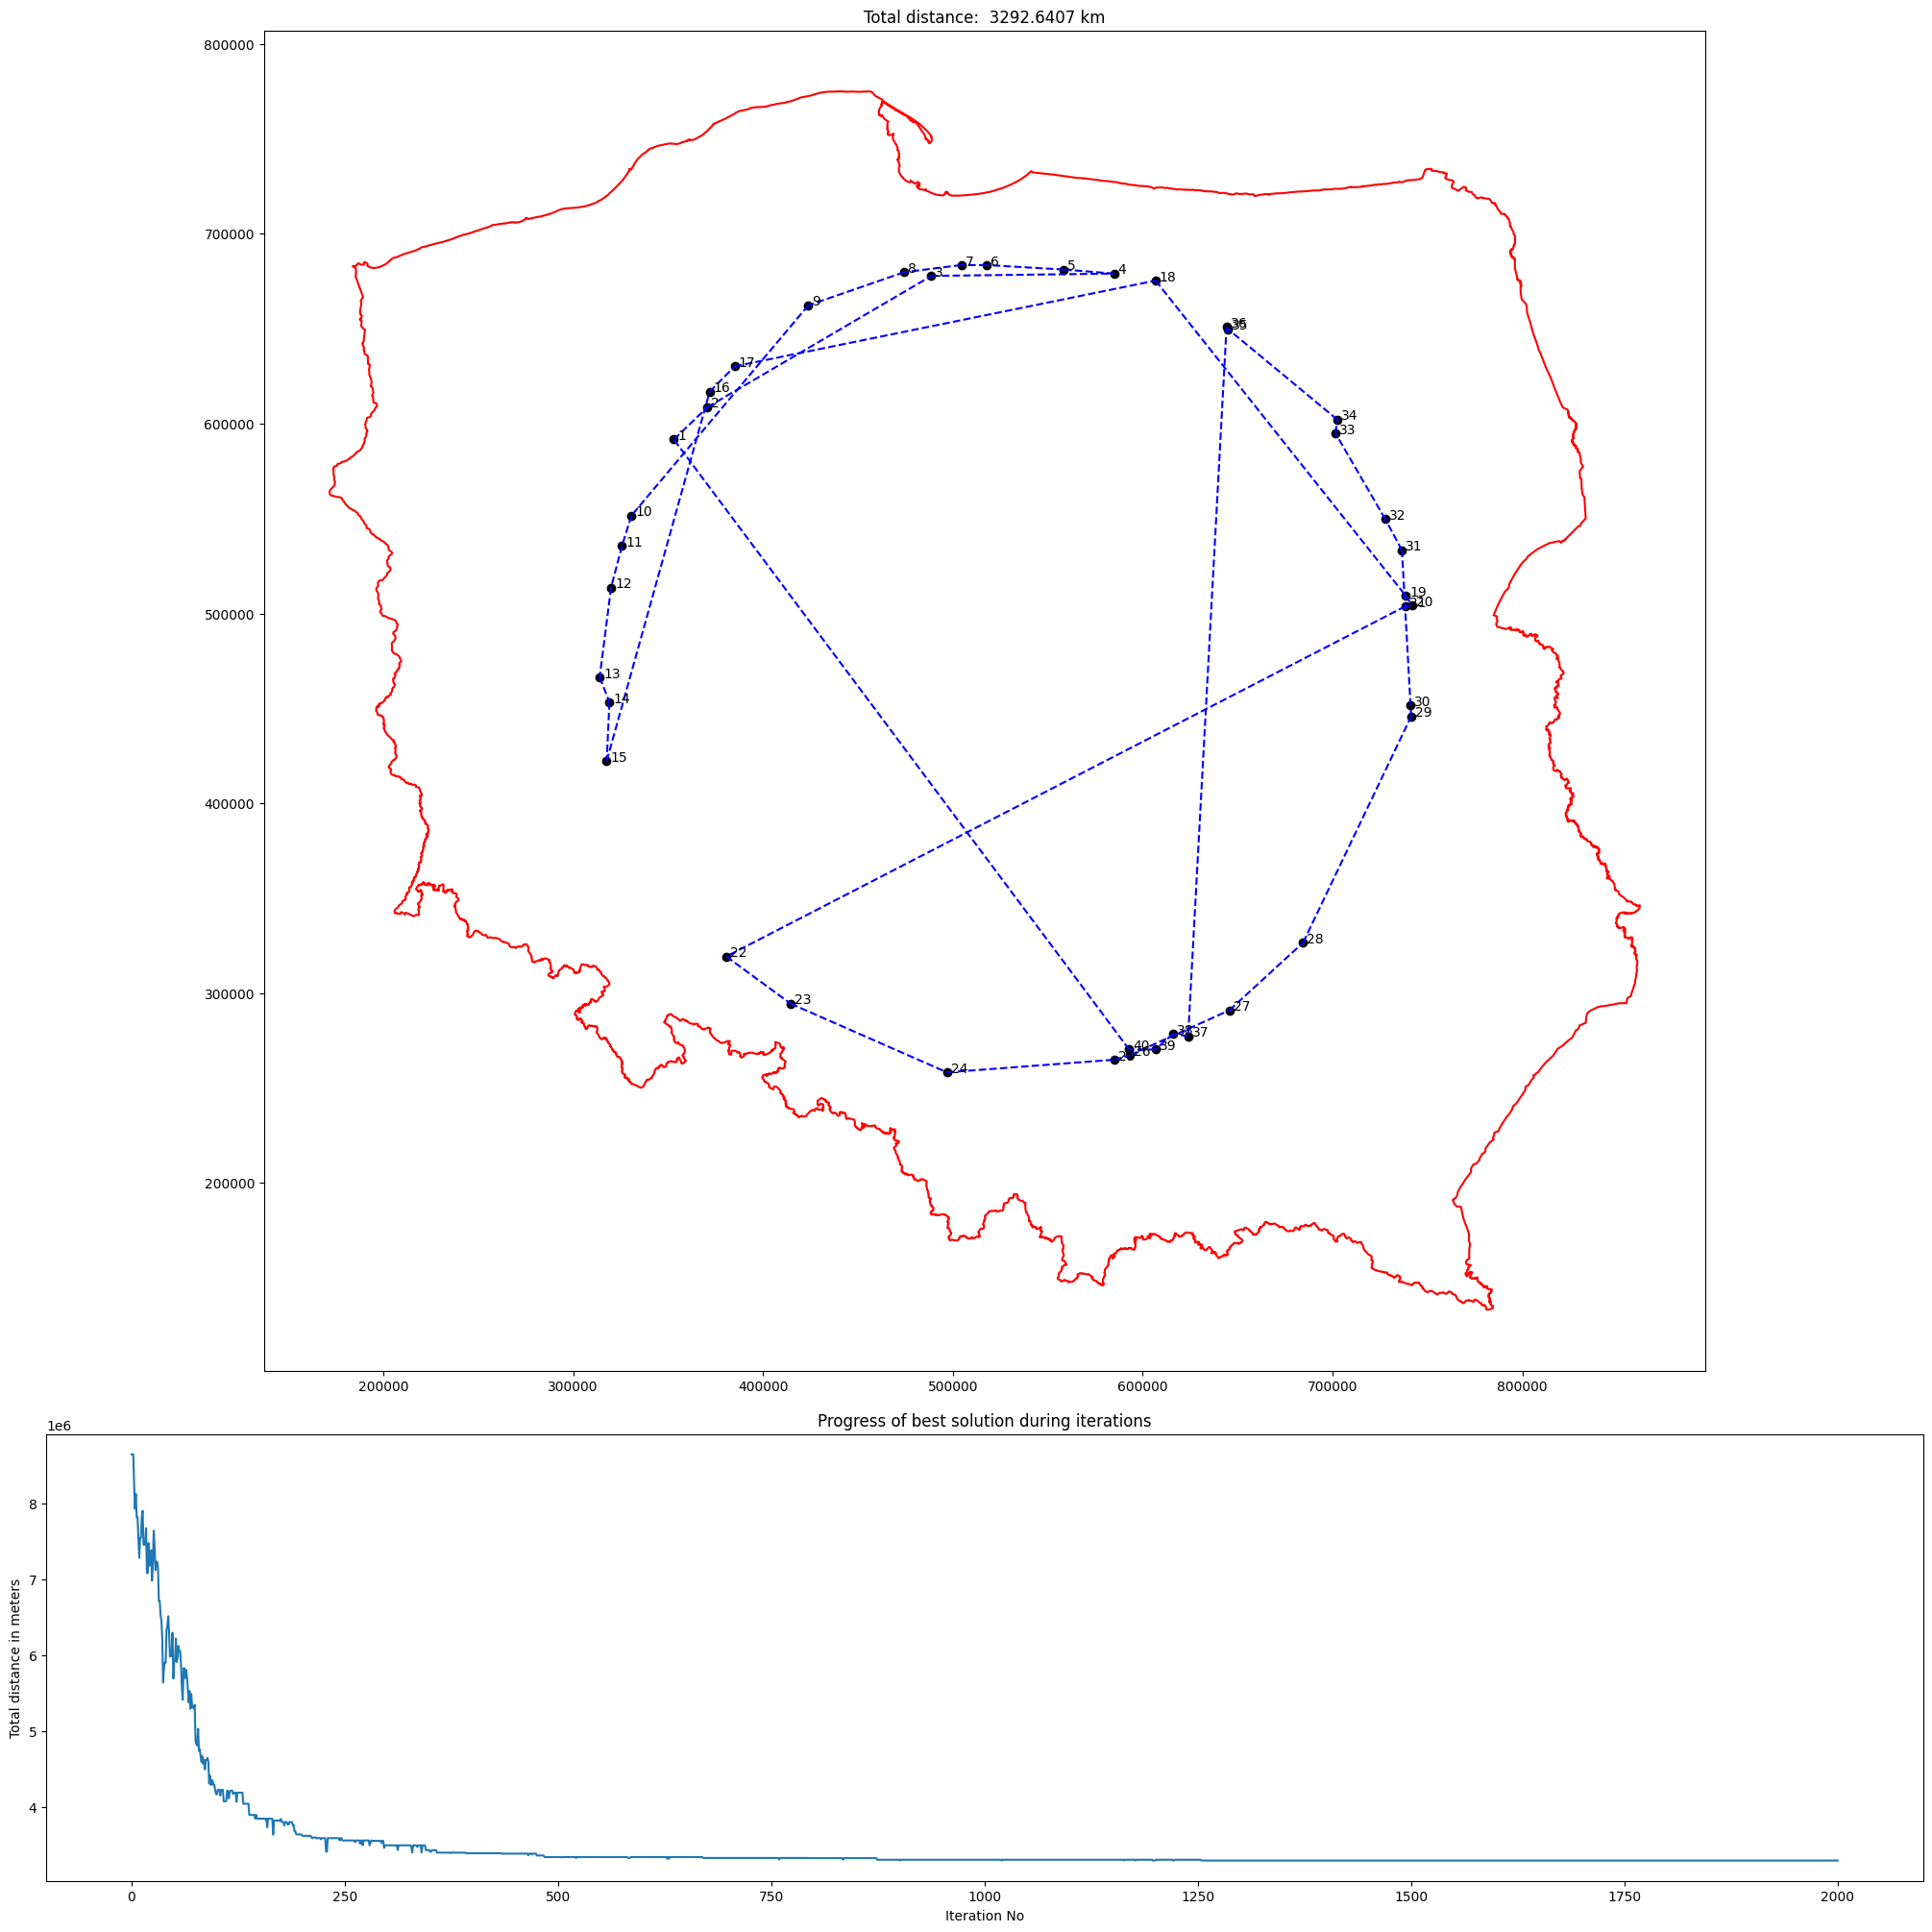

In [47]:
geospatial_salesman(region=Poland, points=points_circle, max_iter=2000)

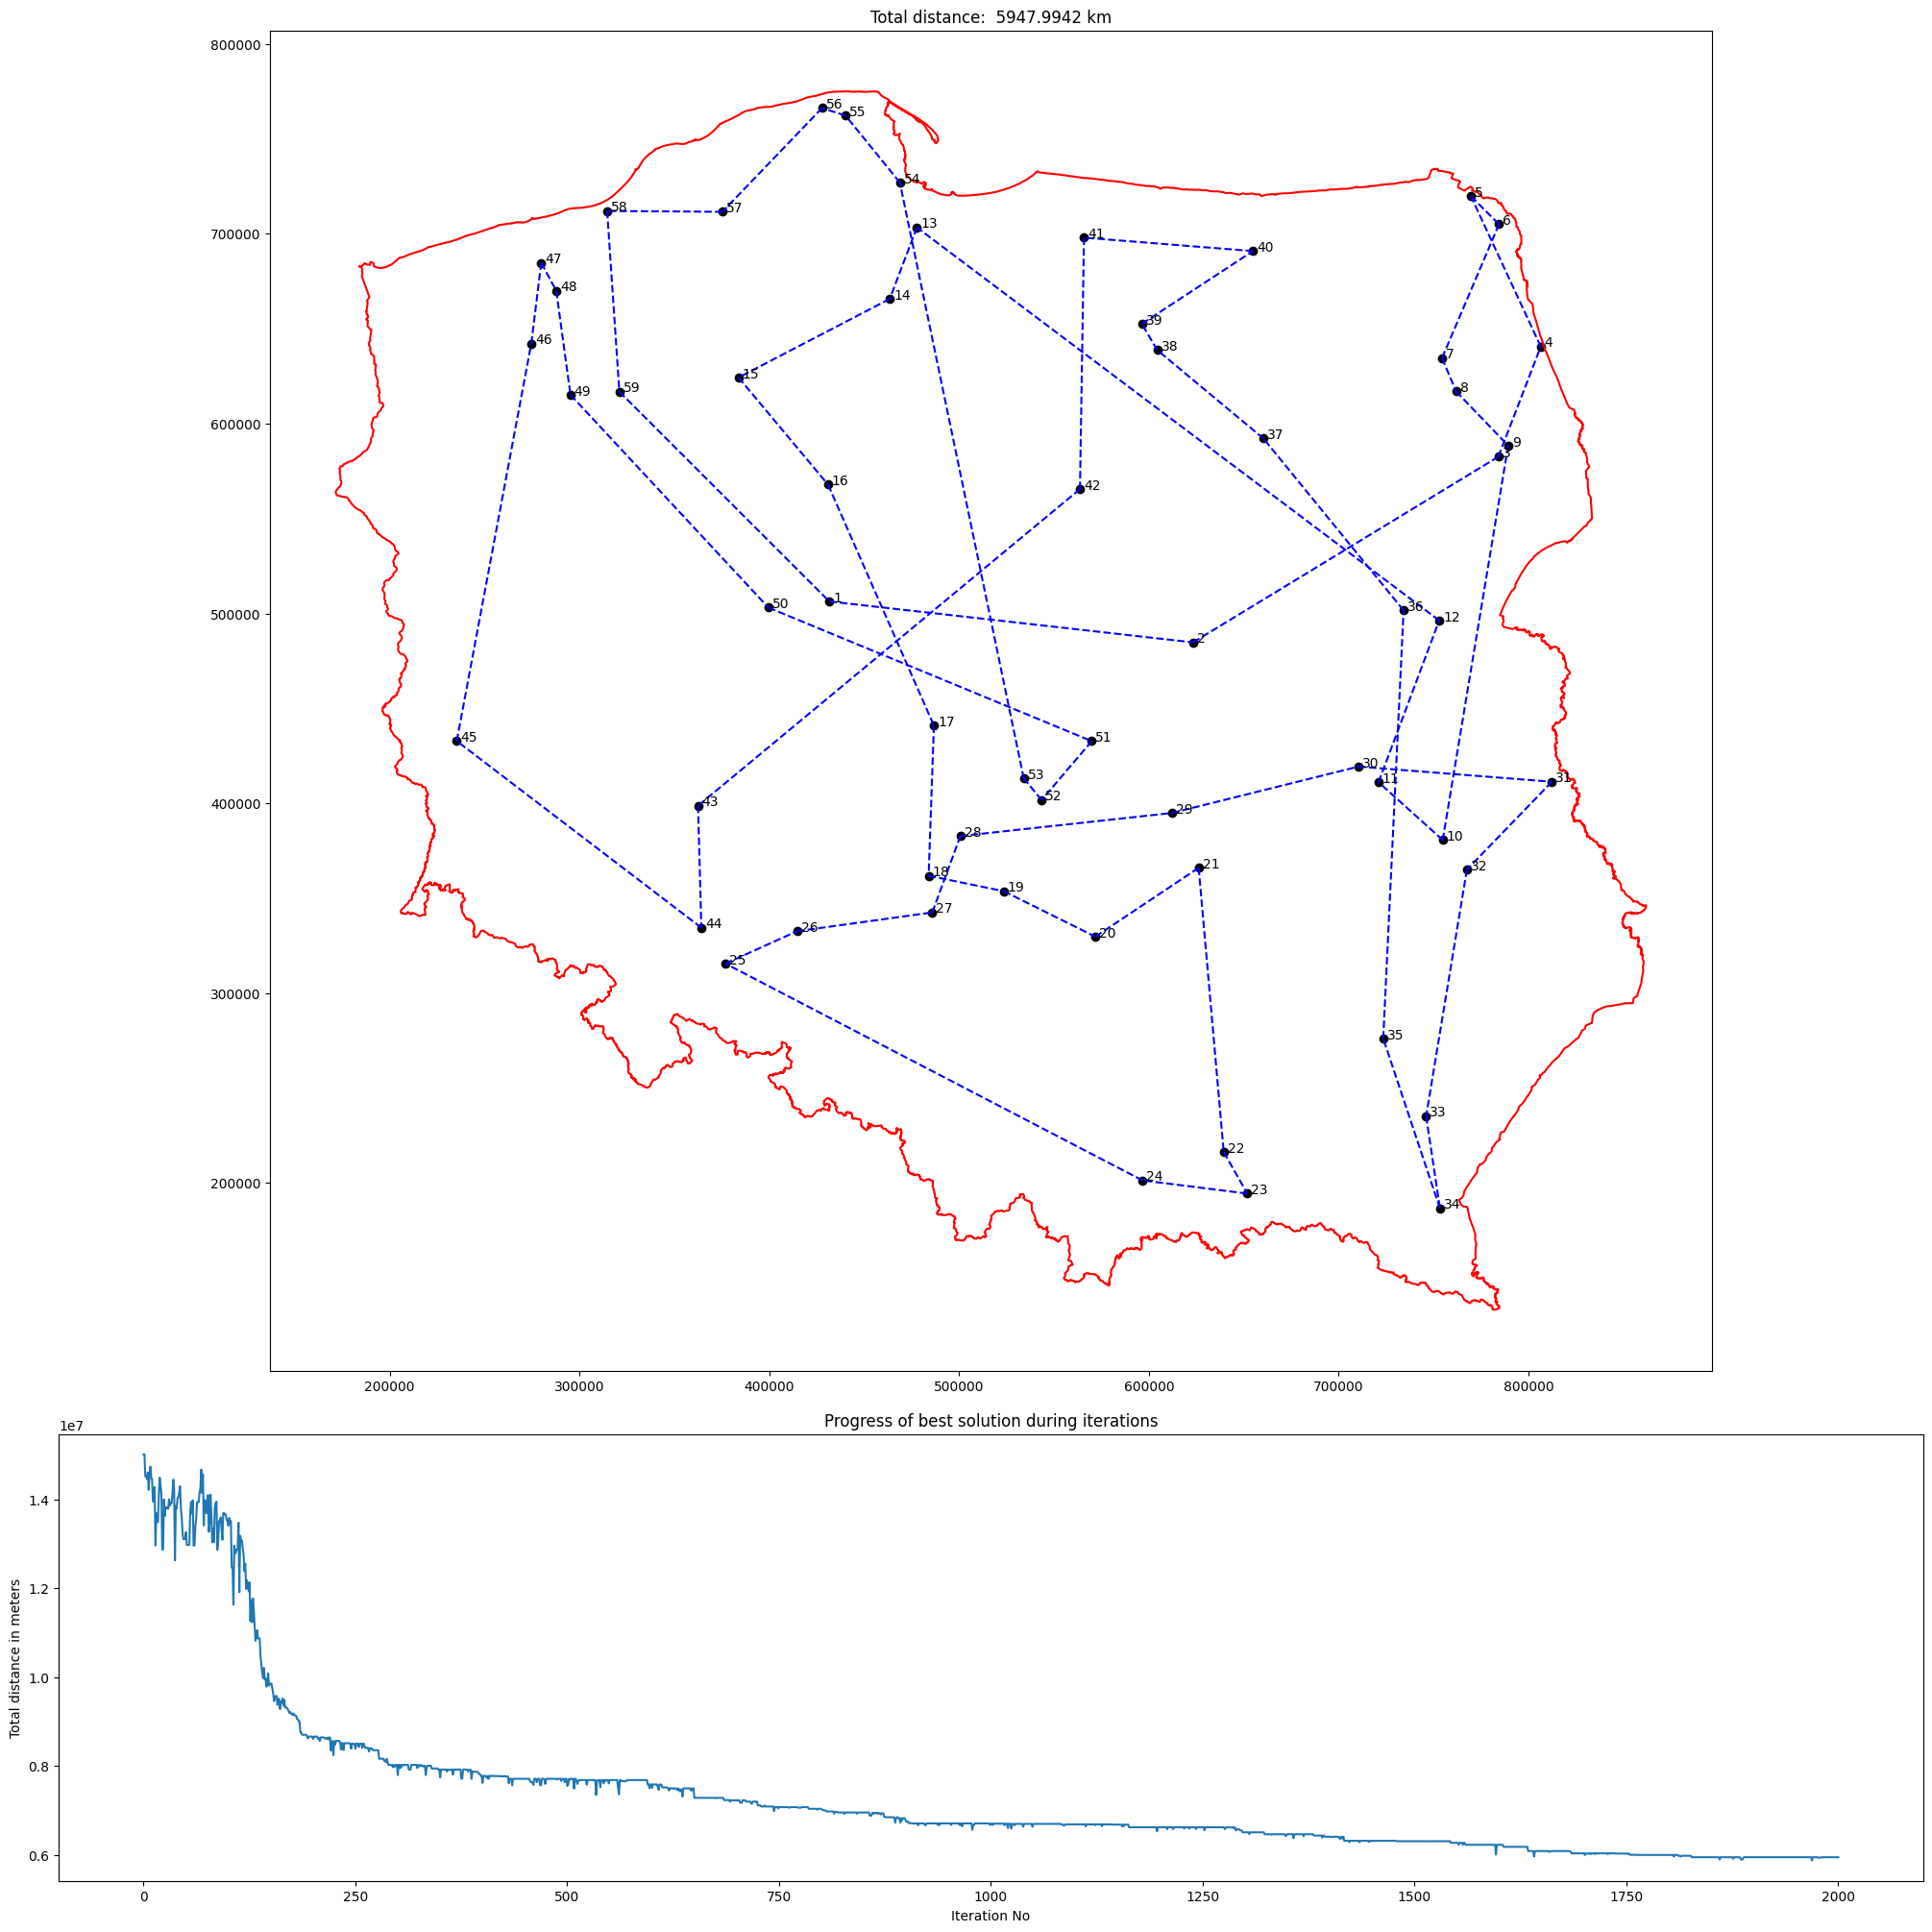

In [48]:
geospatial_salesman(region=Poland, points=points_poisson, max_iter=2000)